# LRFinder Code

In [0]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
#         best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        print(derivatives[n_skip_beginning:-n_skip_end])
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

# Assignment

Summary:
 - Used same n/w as Assignment 13 (achieved 92% accuracy in 100 epochs)
 - Removed the first BatchNormalization from the network
 - Augmented the dataset before running the model to save time
 - Using ImageDataGenerator for horizontal_flip, random_erasing and rotation range (reason: removing it didn't reduce the time)
 - Random erasing of max 16x16
 - Achieved 0.8984 in 21st epoch. Didn't improve after that

In [0]:
import math
import time
import random
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017)

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.regularizers import l2

In [0]:
# Loads CIFAR10 dataset
# 'features' values will have images, 'labels' will have the names represented by the corresponding 'feature' image
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
# Function to calculate the Test Accuracy on test dataset
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# convert class labels to binary class labels
train_labels = utils.to_categorical(train_labels, num_classes)
test_labels = utils.to_categorical(test_labels, num_classes)

In [0]:
BATCH_SIZE = 512 #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 5e-4 #@param ["5e-4", "0.00025", "0.0005"] {type:"raw"}
LEARNING_RATE = 0.4 #@param ["0.4", "0.2", "0.1"] {type:"raw"}
EPOCHS = 24 #@param {type:"slider", min:0, max:100, step:1}
WARMUP = 5 #@param {type:"slider", min:0, max:24, step:1}

In [0]:
def get_random_crop(features, labels):
  temp_features = []
  temp_labels = []
  for idx in range(features.shape[0]):
    img = features[idx]
    lbl = labels[idx]
    
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = 32, 32
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    input_img = img[y:(y+dy), x:(x+dx), :]
      
    temp_features.append(input_img)
    temp_labels.append(lbl)
    
  final_features = np.asarray(temp_features)
  final_labels = np.asarray(temp_labels)
  print(final_features.shape, final_labels.shape)
  return final_features, final_labels

In [0]:
  def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, max_height=None, max_width=None, h_w_const=False, pixel_level=False):
    def eraser(input_img):              
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img

        while True:
          if h_w_const:
            h = max_height
            w = max_width
          else:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            
            if max_height and h>max_height:
              h = max_height
            if max_width and w>max_width:
              w=max_width

          left = np.random.randint(0, img_w)
          top = np.random.randint(0, img_h)

          if left + w <= img_w and top + h <= img_h:
              break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser
  

In [0]:
def normalize_imgs(imgs):
  train_mean = np.mean(imgs, axis=(0,1,2))/255
  train_std = np.std(imgs, axis=(0,1,2))/255
  normalize = lambda x: ((x - train_mean) / train_std).astype('float32')
  return normalize(imgs)
  

def augmentation(train_features, train_labels):
  pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')
  crop_lambda = lambda x, y: get_random_crop(x, y)
  train_features, train_labels = crop_lambda(pad4(train_features), train_labels)
  
  return train_features, train_labels

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Concatenate, GlobalMaxPool2D, Dense, Flatten, Activation

class ConvBN(tf.keras.Model):
  def __init__(self, c_out, batch_norm=True):
    super().__init__()
    self.batch_norm = batch_norm
    self.conv = Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False, kernel_regularizer=l2(5e-4))
    self.bn = BatchNormalization(momentum=MOMENTUM, epsilon=1e-5)

  def call(self, inputs):
    if self.batch_norm:
      return tf.nn.relu(self.bn(self.conv(inputs)))
    else:
      return tf.nn.relu(self.conv(inputs))


In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res1 = ConvBN(c_out)
    self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    res_layer = self.res2(self.res1(h))
    return Concatenate(axis=1)([h, res_layer])


In [0]:
def DavidNet(c=64):
    pool = tf.keras.layers.MaxPooling2D()

    inputs = Input(shape=(32, 32, 3))
    conv1 = ConvBN(c, batch_norm=False)(inputs)

    # Layer 1
    residual1 = ResBlk(c*2, pool)(conv1)

    # Layer 2
    conv2 = ConvBN(c*4)(residual1)
    conv2 = pool(conv2)

    # Layer 3
    residual2 = ResBlk(c*8, pool)(conv2)

    # Classifier
    global_max_pool = GlobalMaxPool2D()(residual2)
    linear = Dense(10, kernel_initializer=init_pytorch, use_bias=False)(global_max_pool)
    output= Activation('softmax')(linear)

    model = Model(inputs=[inputs], outputs=[output])

    return model

# Finding LR

In [0]:
model = DavidNet()
# Improvement: 
#  - Removed lr=0.01
#  - Added nesterov=True
sgd = SGD(momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

In [0]:
datagen = ImageDataGenerator(horizontal_flip=True, preprocessing_function=get_random_eraser(v_l=0, v_h=1))

train_features, test_features = augmentation(train_features, test_features)
train_data = datagen.flow(train_features, train_labels, batch_size = BATCH_SIZE)

### Find LR

In [0]:
sgd = SGD(momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(model)
bs = 512
epoch = 5
steps_per_epoch = train_features.shape[0]/BATCH_SIZE

# train the model
start = time.time()
# Train the model

model_info = lr_finder.find_generator(train_data, 
                                      steps_per_epoch = steps_per_epoch,
                                      start_lr=0.0001, end_lr=1, epochs=5,
                                      validation_data=(test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Epoch 1/5
50/97 [==============>...............] - ETA: 31s - loss: 2.7012 - acc: 0.1911Model took 33.23 seconds to train
Accuracy on test data is: 10.01


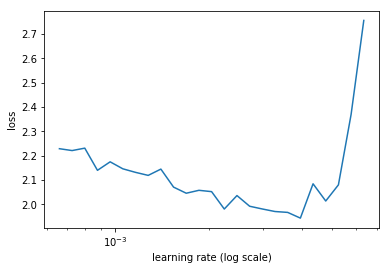

In [0]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

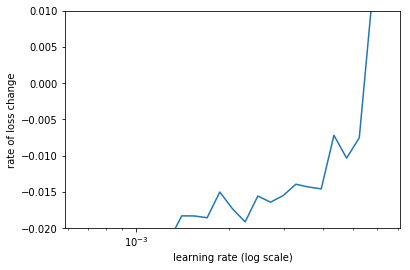

In [0]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.02, 0.01))

In [0]:
sma = 25
n_skip_beginning = 20
n_skip_end = 5

best_lr = lr_finder.get_best_lr(sma, n_skip_beginning=n_skip_beginning, n_skip_end=n_skip_end)
print('The best Learning Rate is: ', best_lr)

[0, 0, 0, 0, 0, -0.07019691467285157, -0.052884092330932615, -0.043852529525756835, -0.030811166763305663, -0.033444995880126956, -0.022097196578979492, -0.024907188415527345, -0.02002235412597656, -0.02122228145599365, -0.016058998107910158, -0.01700880527496338, -0.015097613334655762, -0.017145476341247558, -0.01587963104248047, -0.016178183555603028, -0.00946269989013672, -0.011104841232299805, -0.006786184310913086, 0.004625673294067383, 0.020808677673339843]
The best Learning Rate is:  0.006342203


In [0]:
class LossFunc(Callback):
  def __init__(self, train_data, test_data):
    super().__init__()
    self.train_data = train_data
    
  def on_batch_begin(self, batch, logs):
#     train_x, train_y = self.train_data[batch]
#     print('train_x shape', train_x.shape)
    print(self.model.get_weights())
    print(self.model.loss_weights)
    print(self.model.losses)
  
#     print(self.model.add_loss(1.5))
    
    
  

# Cyclic Learning Rate

In [0]:
from tensorflow.keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
def get_augmented_images(var1, train_features, train_labels):
  new_data = train_features
  new_labels = train_labels
  for _ in range(var1):
    aug_feature, labels = augmentation(train_features, train_labels)
    new_data = np.concatenate((new_data, aug_feature))
    new_labels = np.concatenate((new_labels, labels))
  print(new_data.shape, new_labels.shape)
  return new_data, new_labels
    

# Training

In [0]:
normalized_test_features = normalize_imgs(test_features)
normalized_train_features = normalize_imgs(train_features)

new_features, new_labels = get_augmented_images(8, normalized_train_features, train_labels)


(50000, 32, 32, 3) (50000, 10)
(50000, 32, 32, 3) (50000, 10)
(50000, 32, 32, 3) (50000, 10)
(50000, 32, 32, 3) (50000, 10)
(50000, 32, 32, 3) (50000, 10)
(50000, 32, 32, 3) (50000, 10)
(50000, 32, 32, 3) (50000, 10)
(50000, 32, 32, 3) (50000, 10)
(450000, 32, 32, 3) (450000, 10)


In [0]:
datagen = ImageDataGenerator(horizontal_flip=True, preprocessing_function=get_random_eraser(max_height=16, max_width=16), rotation_range=0.5)
train_data = datagen.flow(new_features, new_labels, batch_size = BATCH_SIZE, shuffle=True)


In [0]:
model = DavidNet()
# Improvement: 
#  - Removed lr=0.01
#  - Added nesterov=True
sgd = SGD(momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# best_lr = 0.013487148
best_lr = 0.006342203
base_lr = best_lr/3
max_lr = best_lr*2
cycles = 2.35

iterations = round(len(train_features)/BATCH_SIZE*EPOCHS)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)
 
clr =  CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size)

steps_per_epoch = math.ceil(train_features.shape[0]/BATCH_SIZE)

start = time.time()
model_info = model.fit_generator(train_data, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                                      validation_data=(normalized_test_features, test_labels), verbose=1,
                                    callbacks=[clr])

# model_info = model.fit(new_features, new_labels, batch_size = BATCH_SIZE, 
#                                       validation_data=(normalized_test_features, test_labels), verbose=1, epochs=EPOCHS,
#                                       steps_per_epoch=steps_per_epoch, callbacks=[clr])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(normalized_test_features, test_labels, model))

Epoch 1/24
98/98 [==============================] - 67s 687ms/step - loss: 2.1137 - acc: 0.3835 - val_loss: 1.9578 - val_acc: 0.4261
Epoch 2/24
98/98 [==============================] - 63s 638ms/step - loss: 1.6996 - acc: 0.5179 - val_loss: 1.9394 - val_acc: 0.4553
Epoch 3/24
98/98 [==============================] - 63s 639ms/step - loss: 1.5208 - acc: 0.5915 - val_loss: 1.3228 - val_acc: 0.6575
Epoch 4/24
98/98 [==============================] - 63s 641ms/step - loss: 1.3529 - acc: 0.6554 - val_loss: 1.3130 - val_acc: 0.6730
Epoch 5/24
98/98 [==============================] - 63s 641ms/step - loss: 1.2643 - acc: 0.6923 - val_loss: 1.2601 - val_acc: 0.7201
Epoch 6/24
98/98 [==============================] - 63s 640ms/step - loss: 1.1941 - acc: 0.7164 - val_loss: 1.3894 - val_acc: 0.7109
Epoch 7/24
98/98 [==============================] - 63s 640ms/step - loss: 1.1343 - acc: 0.7437 - val_loss: 1.3235 - val_acc: 0.7106
Epoch 8/24
98/98 [==============================] - 63s 640ms/step - 